In [1]:
import pandas as pd
import numpy as np
import pickle
from ase import Atoms
from dscribe.descriptors import ACSF
from sklearn.decomposition import PCA

In [ ]:
Atoms(symbols,positions)

In [2]:
structures = pd.read_csv('../Data/structures.csv')

In [4]:
structures.head()

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


### node information

In [3]:
structures[['C', 'F', 'H', 'N', 'O']] = pd.get_dummies(structures.atom)
structures = structures.sort_values(by=['molecule_name', 'atom_index'])

In [4]:
structures_gb = structures.groupby(['molecule_name'])

In [5]:
structures_list = []
count_list = []
mol_list = []
for k,v in structures_gb:
    atom_dict = {'positions':v[['x','y','z']].values.tolist(),
                 'symbols':[i[0] for i in v[['atom']].values.tolist()]
                 }
    atom = Atoms(**atom_dict)
    dist = atom.get_all_distances()
    d = dist.shape[0]
    dist = dist[np.tril_indices(d,-1)]
    r_info = np.array([dist.max(),dist.min(),dist.mean(),dist.std()])
    
    acsf = ACSF(species=['C', 'F', 'H', 'N', 'O'],
                rcut=8.0,
                g2_params=[[1, 1], [1, 2], [1, 3], [1, 4], [1, 5], [1, 6]],
                g4_params=[[1, 1, 1], [1, 2, 1], [1, 4, 1], [1, 1, -1], [1, 2, -1], [1, 4, -1], \
                           [2, 1, 1], [2, 2, 1], [2, 4, 1], [2, 1, -1], [2, 2, -1], [2, 4, -1]])
    acsf_np = acsf.create(atom)
    temp = np.concatenate([acsf_np,v[['C', 'F', 'H', 'N', 'O']].values,\
                                         np.tile(r_info,(d,1))],1)
    structures_list.append(temp)
    count_list.append(d)
    mol_list.append(k)

In [6]:
structures_list = np.concatenate(structures_list,0)

In [7]:
count_list = np.cumsum(np.array(count_list))

In [15]:
model = PCA(32,svd_solver='randomized',whiten=True)

In [16]:
structures_pca = model.fit_transform(structures_list).astype(np.float32)

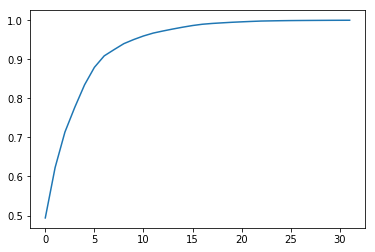

In [17]:
import matplotlib.pyplot as plt
plt.plot(model.explained_variance_ratio_.cumsum())

In [18]:
model.explained_variance_ratio_.sum()

0.9997958075182168

In [19]:
structures_pca2 = np.split(structures_pca,count_list)

In [27]:
len(structures_pca2[:-1]) - len(mol_list)

0

In [28]:
structures_dict = dict(zip(mol_list,structures_pca2[:-1]))

In [30]:
with open('../Data/structures_dict_ACSF_PCA.pickle', 'wb') as handle:
    pickle.dump(structures_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)